In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.distributions import uniform

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import seaborn as sns
import matplotlib.pyplot as plt

# Exploring batch normalization

### Defining Pytorch dataset and loader

In [2]:
dataset = datasets.MNIST(
    root='../datasets',
    download=True,
    train = True,
    transform=transforms.ToTensor()
)

loader = DataLoader(
    dataset,
    num_workers=4,
    batch_size=512,
    shuffle=True
)

### Defining custom batch norm module

In [3]:
class CustomBatchNorm(nn.Module):

    def __init__(self, in_size, momentum=0.9, eps = 1e-5):
        super(CustomBatchNorm, self).__init__()
        
        self.momentum = momentum
        self.insize = in_size
        self.eps = eps
        
        U = uniform.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))
        self.gamma = nn.Parameter(U.sample(torch.Size([self.insize])).view(self.insize))
        self.beta = nn.Parameter(torch.zeros(self.insize))
            
        self.register_buffer('running_mean', torch.zeros(self.insize))
        self.register_buffer('running_var', torch.ones(self.insize))
        
        self.running_mean.zero_()
        self.running_var.fill_(1)


    def forward(self, input):
        
        X = input

        if len(X.shape) not in (2, 4):
            raise ValueError("only support dense or 2dconv")
        
        # dense layer
        elif len(X.shape) == 2:
            if self.training:
                mean = torch.mean(X, axis=0)
                variance = torch.mean((X-mean)**2, axis=0)
                
                self.running_mean = (self.momentum * self.running_mean) + (1.0-self.momentum) * mean
                self.running_var = (self.momentum * self.running_var) + (1.0-self.momentum) * (input.shape[0]/(input.shape[0]-1)*variance)
            
            else:
                mean = self.running_mean
                variance = self.running_var
                
            X_hat = (X-mean) * 1.0 /torch.sqrt(variance + self.eps)
            out = self.gamma * X_hat + self.beta

        elif len(X.shape) == 4:
            if self.training:
                N, C, H, W = X.shape
                mean = torch.mean(X, axis = (0, 2, 3))
                variance = torch.mean((X - mean.reshape((1, C, 1, 1))) ** 2, axis=(0, 2, 3))
                
                self.running_mean = (self.momentum * self.running_mean) + (1.0-self.momentum) * mean
                self.running_var = (self.momentum * self.running_var) + (1.0-self.momentum) * (input.shape[0]/(input.shape[0]-1)*variance)
            else:
                mean = self.running_mean
                var = self.running_var
                
            X_hat = (X - mean.reshape((1, C, 1, 1))) * 1.0 / torch.sqrt(variance.reshape((1, C, 1, 1)) + self.eps)
            out = self.gamma.reshape((1, C, 1, 1)) * X_hat + self.beta.reshape((1, C, 1, 1))
        
        return out

### Example neural net

In [4]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28 * 28, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [5]:
class SimpleNetBN(nn.Module):
    def __init__(self):
        super(SimpleNetBN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28 * 28, 64),
            CustomBatchNorm(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            CustomBatchNorm(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Experiment of training with and without Batch Norm

In [6]:
net_without_batch_norm = SimpleNet()

In [7]:
net_with_batch_norm = SimpleNetBN()

In [8]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(net_without_batch_norm.parameters(), lr=0.01)
opt_bn = optim.SGD(net_with_batch_norm.parameters(), lr=0.01)

[1,   512] loss: 0.058  loss_bn: 0.060
[1, 20992] loss: 2.301  loss_bn: 2.086
[1, 41472] loss: 2.292  loss_bn: 1.734
[2,   512] loss: 0.057  loss_bn: 0.035
[2, 20992] loss: 2.271  loss_bn: 1.297
[2, 41472] loss: 2.259  loss_bn: 1.132
[3,   512] loss: 0.056  loss_bn: 0.024
[3, 20992] loss: 2.222  loss_bn: 0.888
[3, 41472] loss: 2.194  loss_bn: 0.784
[4,   512] loss: 0.054  loss_bn: 0.018
[4, 20992] loss: 2.123  loss_bn: 0.639
[4, 41472] loss: 2.068  loss_bn: 0.592
[5,   512] loss: 0.050  loss_bn: 0.013
[5, 20992] loss: 1.924  loss_bn: 0.501
[5, 41472] loss: 1.836  loss_bn: 0.477
[6,   512] loss: 0.042  loss_bn: 0.011
[6, 20992] loss: 1.609  loss_bn: 0.417
[6, 41472] loss: 1.480  loss_bn: 0.404
[7,   512] loss: 0.032  loss_bn: 0.010
[7, 20992] loss: 1.248  loss_bn: 0.373
[7, 41472] loss: 1.137  loss_bn: 0.353
[8,   512] loss: 0.026  loss_bn: 0.009
[8, 20992] loss: 0.971  loss_bn: 0.327
[8, 41472] loss: 0.911  loss_bn: 0.323
[9,   512] loss: 0.022  loss_bn: 0.008
[9, 20992] loss: 0.797  l

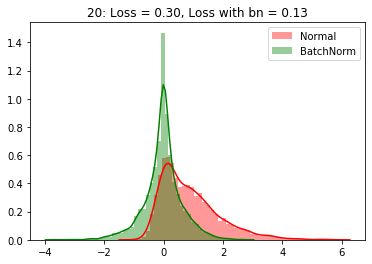

----------------------


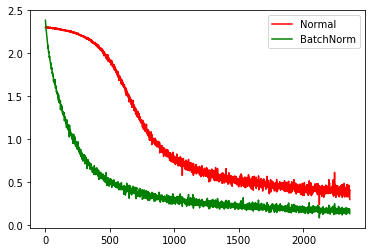

In [9]:
loss_arr = []
loss_bn_arr = []

max_epochs = 20

for epoch in range(max_epochs):
    
    running_loss = 0.0
    running_loss_bn = 0.0
    for i, data in enumerate(loader, 0):

        inputs, labels = data

        # training steps for normal model
        opt.zero_grad()
        outputs = net_without_batch_norm(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        # training steps for bn model
        opt_bn.zero_grad()
        outputs_bn = net_with_batch_norm(inputs)
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()
        
        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())
        
        # print statistics
        running_loss += loss.item()
        running_loss_bn += loss_bn.item()
        if i % 40 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f  loss_bn: %.3f'%
                  (epoch + 1, (i + 1)*512, running_loss / 40, running_loss_bn / 40))
            running_loss = 0.0
            running_loss_bn = 0.0
    print("="*40)
            

print("="*10 + " Epoch {} ".format(epoch+1) + "="*10)
inputs = inputs.view(inputs.size(0), -1)

net_without_batch_norm.eval()
net_with_batch_norm.eval()

a = net_without_batch_norm.classifier[0](inputs)
a = a.detach().numpy().ravel()
sns.distplot(a, kde=True, color='r', label='Normal') 

b = net_with_batch_norm.classifier[0](inputs)
b = net_with_batch_norm.classifier[1](b)
b = b.detach().numpy().ravel()
sns.distplot(b, kde=True, color='g', label='BatchNorm') 

plt.title('%d: Loss = %0.2f, Loss with bn = %0.2f' % (epoch+1, loss.item(), loss_bn.item()))
plt.legend()
plt.savefig("notes/imgs/activation-distribution.png", dpi=100)
plt.show()
plt.pause(0.5)

net_without_batch_norm.train()
net_with_batch_norm.train()
print('----------------------')

plt.plot(loss_arr, 'r', label='Normal')
plt.plot(loss_bn_arr, 'g', label='BatchNorm')
plt.savefig("notes/imgs/training-loss.png", dpi=100)
plt.legend()
plt.show()
    